<a href="https://colab.research.google.com/github/santhoshmani888/gaussain_splat_toy/blob/main/2D_GSplat(not_working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from PIL import Image
import cv2
import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# clip model for clip loss

In [ ]:
import torch
from PIL import Image
import open_clip
clip_model = 'ViT-B-32'

model, _, preprocess = open_clip.create_model_and_transforms(clip_model, pretrained='laion2b_s34b_b79k')

model.requires_grad_(False).cuda()
tokenizer = open_clip.get_tokenizer(oclip)

In [ ]:
from torchvision.transforms import Normalize

clip_tensor = Normalize(mean=model.visual.image_mean, std=model.visual.image_std)

In [ ]:
def random_crops(img, n, resize_to=224, min_size=0.5, max_size=1.0):
    sizes = torch.rand(n) * (max_size - min_size) + min_size
    top_left = torch.rand(n, 2) * (1.0 - sizes[:, None])
    transforms = torch.eye(2).unsqueeze(0).repeat(n, 1, 1) * sizes[:, None, None]
    transforms = torch.cat([transforms, top_left[:, :, None]], dim=-1)
    grids = torch.nn.functional.affine_grid(transforms, [n, img.shape[1], resize_to, resize_to], align_corners=True).to(img.device)
    return torch.nn.functional.grid_sample(img.repeat(n, 1, 1, 1), grids, align_corners=True)


In [ ]:
# 2d image gaussian mixture

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def prepare_covariance(sigma_x, sigma_y, rho):
    batch_size = sigma_x.shape[0]
    sigma_x = sigma_x.view(batch_size, 1, 1).float()
    sigma_y = sigma_y.view(batch_size, 1, 1).float()
    rho = rho.view(batch_size, 1, 1).float()

    cov = torch.stack(
        [
            torch.stack([sigma_x ** 2, rho * sigma_x * sigma_y], dim=-1),
            torch.stack([rho * sigma_x * sigma_y, sigma_y ** 2], dim=-1),
        ],
        dim=-2,
    )

    det = (sigma_x ** 2) * (sigma_y ** 2) - (rho * sigma_x * sigma_y) ** 2
    if (det <= 0).any():
        raise ValueError("Covariance matrix must be positive semi-definite")

    inv_cov = torch.inverse(cov)
    return inv_cov

def prepare_kernel(kernel_size, device):
    start = torch.tensor([-5.0], device=device).view(-1, 1).float()
    end = torch.tensor([5.0], device=device).view(-1, 1).float()
    linspace = torch.linspace(0, 1, steps=kernel_size, device=device).float()
    ax_batch = start + (end - start) * linspace

    ax_batch_x = ax_batch.unsqueeze(-1).expand(-1, -1, kernel_size)
    ax_batch_y = ax_batch.unsqueeze(1).expand(-1, kernel_size, -1)

    xx, yy = ax_batch_x, ax_batch_y

    xy = torch.stack([xx, yy], dim=-1)
    return xy

def normalize_kernel(kernel, batch_size):
    kernel_max_1, _ = kernel.max(dim=-1, keepdim=True)
    kernel_max_2, _ = kernel_max_1.max(dim=-2, keepdim=True)
    kernel_normalized = kernel / kernel_max_2
    kernel_reshaped = kernel_normalized.repeat(1, 4, 1).view(batch_size * 4, kernel.shape[1], kernel.shape[2])
    return kernel_reshaped.unsqueeze(0).reshape(batch_size, 4, kernel.shape[1], kernel.shape[2])

def prepare_image(kernel_rgba, image_size):
    pad_h = image_size[0] - kernel_rgba.shape[2]
    pad_w = image_size[1] - kernel_rgba.shape[3]

    if pad_h < 0 or pad_w < 0:
        raise ValueError("Kernel size should be smaller or equal to the image size.")

    padding = (
        pad_w // 2,
        pad_w // 2 + pad_w % 2,
        pad_h // 2,
        pad_h // 2 + pad_h % 2,
    )

    kernel_rgba_padded = F.pad(kernel_rgba, padding, "constant", 0)
    return kernel_rgba_padded

def apply_affine_transformation(kernel_rgba_padded, coords, colours, device):
    b, c, h, w = kernel_rgba_padded.shape
    theta = torch.zeros(b, 2, 3, dtype=torch.float32, device=device)
    theta[:, 0, 0] = 1.0
    theta[:, 1, 1] = 1.0
    theta[:, :, 2] = coords.float()

    grid = F.affine_grid(theta, size=(b, c, h, w), align_corners=True)
    kernel_rgba_padded_translated = F.grid_sample(
        kernel_rgba_padded, grid, align_corners=True
    )

    rgba_values_reshaped = colours.unsqueeze(-1).unsqueeze(-1)
    final_image_layers = rgba_values_reshaped * kernel_rgba_padded_translated
    final_image = final_image_layers.sum(dim=0)
    final_image = torch.clamp(final_image, 0, 1)
    final_image = final_image.permute(1, 2, 0)

    return final_image

def gaussian_2d_mix_image(kernel_size, sigma_x, sigma_y, rho, coords, colours, image_size=(256, 256, 4), device="cpu"):
    batch_size = colours.shape[0]
    inv_covariance = prepare_covariance(sigma_x, sigma_y, rho)
    xy = prepare_kernel(kernel_size, device)
    z = torch.einsum("b...i,b...ij,b...j->b...", xy, -0.5 * inv_covariance, xy)

    pi = torch.tensor(np.pi, device=device).float()
    det_covariance = torch.det(inv_covariance)
    kernel = torch.exp(z) / (2 * pi * torch.sqrt(det_covariance).view(batch_size, 1, 1))

    kernel_reshaped = normalize_kernel(kernel, batch_size)
    img = prepare_image(kernel_reshaped, image_size)
    final_image = apply_affine_transformation(img, coords, colours, device)

    return final_image


In [ ]:
# data sampling

In [ ]:

def sample_data_points(input_image, device, batch_size=3):
    width, height, channels = input_image.shape

    flattened_indices = torch.arange(width * height, device=device)
    random_indices = torch.randint(0, width * height, size=(batch_size,), device=device)

    random_coords = torch.stack([random_indices % width, random_indices // width], dim=1)
    random_coords = random_coords.float() / torch.tensor([width, height], dtype=torch.float32, device=device)

    selected_pixels = input_image.view(-1, channels)[random_indices]
    colours = selected_pixels[:, :channels-1]  # Extract RGB values
    alpha_values = selected_pixels[:, channels-1:]  # Extract alpha values

    return random_coords, torch.cat([colours, alpha_values], dim=1)

In [ ]:
#loss

In [ ]:
#
# Copyright (C) 2023, Inria
# GRAPHDECO research group, https://team.inria.fr/graphdeco
# All rights reserved.
#
# This software is free for non-commercial, research and evaluation use
# under the terms of the LICENSE.md file.
#
# For inquiries contact  george.drettakis@inria.fr
#

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from math import exp

def l1_loss(network_output, gt):
    return torch.abs((network_output - gt)).mean()

def l2_loss(network_output, gt):
    return ((network_output - gt) ** 2).mean()

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def ssim(img1, img2, window_size=11, size_average=True):
    channel = img1.size(-3)
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

In [ ]:
# load input image

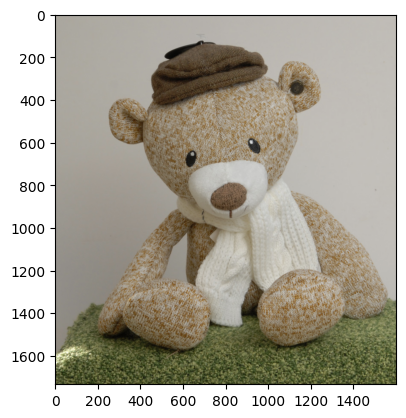

In [ ]:

# Load your image with alpha channel
pil_image = Image.open('Ted_toy.png')
prompt = "teddy bear doll on green surface"

plt.imshow(pil_image)


In [ ]:
#params

In [ ]:

# Training parameters
batch_size = 3
num_samples = 25000  # Number of samples for coordinates
num_epochs = 2500  # Number of epochs
image_size = 256

In [ ]:
# train [TODO - add densify_and_prune on gradients]

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

text = tokenizer([prompt]).cuda()

# Create a directory with a timestamp
# log_dir = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# os.makedirs(log_dir, exist_ok=True)
# writer = SummaryWriter(os.path.join(log_dir, 'logs'))

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize the image to 256x256
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))  # Normalizes the image
])


tensor_image = transform(pil_image)

# Ensure the image has an alpha channel, if not add one
if tensor_image.shape[0] == 3:
    alpha_channel = torch.ones_like(tensor_image[0:1, :, :])  # Create a white alpha channel
    tensor_image = torch.cat((tensor_image, alpha_channel), dim=0)

# Resize to match the specified shape (256x256x4)
tensor_image = torch.nn.functional.pad(tensor_image, (0, 0, 0, 0, 0, 4 - tensor_image.shape[0]), value=0)
tensor_image = tensor_image.permute(1, 2, 0)

#print(tensor_image.shape)  # Output: torch.Size([256, 256, 4])

image_size = tuple(tensor_image.shape)





image_array = tensor_image.to(device)
target_tensor = tensor_image.to(device)

#print("shapes",image_array.shape,target_tensor.shape)


rho = torch.tensor(2 * np.random.rand(batch_size) - 1, device=device, requires_grad=True).unsqueeze(1)
sigma_x = torch.tensor(np.random.rand(batch_size) * 2, device=device, requires_grad=True).unsqueeze(1)
sigma_y = torch.tensor(np.random.rand(batch_size) * 2, device=device, requires_grad=True).unsqueeze(1)

coords, colours = sample_data_points(image_array, device,batch_size)

coords = coords.to(device)
colours = colours.to(device)

# params to optimize

W_mat = torch.cat([colours, coords, sigma_x, sigma_y, rho], dim=1)
W = nn.Parameter(W_mat, requires_grad=True)

optimizer = optim.Adam([W], lr=0.001)
loss_history = []
for epoch in range(num_epochs):
    coords, colours = sample_data_points(image_array, device)

    generated_image = gaussian_2d_mix_image(
        kernel_size=150,
        sigma_x=sigma_x,
        sigma_y=sigma_y,
        rho=rho,
        coords=coords,
        colours=colours,
        image_size=image_size,
        device=device
    )
    # text_vec = model.encode_text(text).float()
    # text_vec = text_vec / text_vec.norm(dim=-1, keepdim=True)

    # crops = random_crops(generated_image, 32, min_size=0.7, max_size=0.9)
    # img_vec = model.encode_image(clip_tensor(crops)).float()
    # img_vec = img_vec / img_vec.norm(dim=-1, keepdim=True)

    # sim = img_vec @ text_vec.T
    # clip_loss = -sim.mean()
    loss = l1_loss(generated_image, target_tensor) + (1-ssim(generated_image, target_tensor)) #+ clip_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")





Epoch [0/2500], Loss: 1.347884178161621
Epoch [100/2500], Loss: 1.4118456840515137
Epoch [200/2500], Loss: 1.363973617553711
Epoch [300/2500], Loss: 1.359062671661377
Epoch [400/2500], Loss: 1.3999508619308472
Epoch [500/2500], Loss: 1.3425183296203613
Epoch [600/2500], Loss: 1.3915457725524902
Epoch [700/2500], Loss: 1.3122433423995972
Epoch [800/2500], Loss: 1.411275863647461
Epoch [900/2500], Loss: 1.3592838048934937
Epoch [1000/2500], Loss: 1.3325910568237305
Epoch [1100/2500], Loss: 1.366281270980835
Epoch [1200/2500], Loss: 1.3476905822753906
Epoch [1300/2500], Loss: 1.373128056526184
Epoch [1400/2500], Loss: 1.3001255989074707
Epoch [1500/2500], Loss: 1.3350329399108887
Epoch [1600/2500], Loss: 1.379549503326416
Epoch [1700/2500], Loss: 1.347773551940918
Epoch [1800/2500], Loss: 1.3583073616027832
Epoch [1900/2500], Loss: 1.3775014877319336
Epoch [2000/2500], Loss: 1.3865203857421875
Epoch [2100/2500], Loss: 1.3971657752990723
Epoch [2200/2500], Loss: 1.3211883306503296
Epoch [2

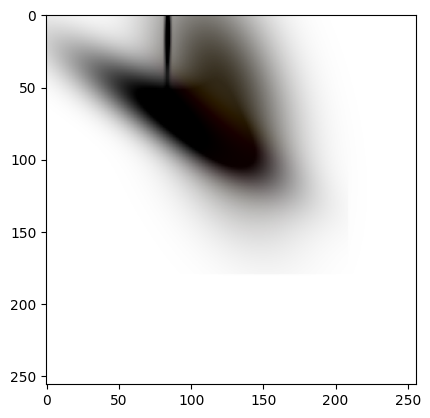

In [ ]:
plt.imshow(generated_image.cpu().detach().numpy())

In [ ]:
#
# Copyright (C) 2023, Inria
# GRAPHDECO research group, https://team.inria.fr/graphdeco
# All rights reserved.
#
# This software is free for non-commercial, research and evaluation use
# under the terms of the LICENSE.md file.
#
# For inquiries contact  george.drettakis@inria.fr
#


# def densify_and_split(self, grads, grad_threshold, scene_extent, N=2):
#         n_init_points = self.get_xyz.shape[0]
#         # Extract points that satisfy the gradient condition
#         padded_grad = torch.zeros((n_init_points), device="cuda")
#         padded_grad[:grads.shape[0]] = grads.squeeze()
#         selected_pts_mask = torch.where(padded_grad >= grad_threshold, True, False)
#         selected_pts_mask = torch.logical_and(selected_pts_mask,
#                                               torch.max(self.get_scaling, dim=1).values > self.percent_dense*scene_extent)

#         stds = self.get_scaling[selected_pts_mask].repeat(N,1)
#         means =torch.zeros((stds.size(0), 3),device="cuda")
#         samples = torch.normal(mean=means, std=stds)
#         rots = build_rotation(self._rotation[selected_pts_mask]).repeat(N,1,1)
#         new_xyz = torch.bmm(rots, samples.unsqueeze(-1)).squeeze(-1) + self.get_xyz[selected_pts_mask].repeat(N, 1)
#         new_scaling = self.scaling_inverse_activation(self.get_scaling[selected_pts_mask].repeat(N,1) / (0.8*N))
#         new_rotation = self._rotation[selected_pts_mask].repeat(N,1)
#         new_features_dc = self._features_dc[selected_pts_mask].repeat(N,1,1)
#         new_features_rest = self._features_rest[selected_pts_mask].repeat(N,1,1)
#         new_opacity = self._opacity[selected_pts_mask].repeat(N,1)

#         self.densification_postfix(new_xyz, new_features_dc, new_features_rest, new_opacity, new_scaling, new_rotation)

#         prune_filter = torch.cat((selected_pts_mask, torch.zeros(N * selected_pts_mask.sum(), device="cuda", dtype=bool)))
#         self.prune_points(prune_filter)

#     def densify_and_clone(self, grads, grad_threshold, scene_extent):
#         # Extract points that satisfy the gradient condition
#         selected_pts_mask = torch.where(torch.norm(grads, dim=-1) >= grad_threshold, True, False)
#         selected_pts_mask = torch.logical_and(selected_pts_mask,
#                                               torch.max(self.get_scaling, dim=1).values <= self.percent_dense*scene_extent)

#         new_xyz = self._xyz[selected_pts_mask]
#         new_features_dc = self._features_dc[selected_pts_mask]
#         new_features_rest = self._features_rest[selected_pts_mask]
#         new_opacities = self._opacity[selected_pts_mask]
#         new_scaling = self._scaling[selected_pts_mask]
#         new_rotation = self._rotation[selected_pts_mask]

#         self.densification_postfix(new_xyz, new_features_dc, new_features_rest, new_opacities, new_scaling, new_rotation)

#     def densify_and_prune(self, max_grad, min_opacity, extent, max_screen_size):
#         grads = self.xyz_gradient_accum / self.denom
#         grads[grads.isnan()] = 0.0

#         self.densify_and_clone(grads, max_grad, extent)
#         self.densify_and_split(grads, max_grad, extent)

#         prune_mask = (self.get_opacity < min_opacity).squeeze()
#         if max_screen_size:
#             big_points_vs = self.max_radii2D > max_screen_size
#             big_points_ws = self.get_scaling.max(dim=1).values > 0.1 * extent
#             prune_mask = torch.logical_or(torch.logical_or(prune_mask, big_points_vs), big_points_ws)
#         self.prune_points(prune_mask)

#         torch.cuda.empty_cache()

#     def add_densification_stats(self, viewspace_point_tensor, update_filter):
#         self.xyz_gradient_accum[update_filter] += torch.norm(viewspace_point_tensor.grad[update_filter,:2], dim=-1, keepdim=True)
#         self.denom[update_filter] += 1